In [95]:
# %%
from SonicBatt import utils
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'multi-cell_ml')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
ancillary_data_path = os.path.join(study_path, 'Ancillary Data')
models_path = os.path.join(study_path, 'Models', 'Regression')

database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
selected_cells = database.loc[:,'cell_id'].to_list()
df_cell_aliases =  pd.read_excel(os.path.join(data_path, 'database.xlsx'),
                              sheet_name='cell_aliases')
cell_aliases = {}
for _, row in df_cell_aliases.iterrows():
    cell_aliases[row['cell_id']] = row['cell_alias']

parquet_filename = 'signals_peaks_fft.parquet'
parquet_filepath = os.path.join(ancillary_data_path, parquet_filename)
df = pd.read_parquet(parquet_filepath)
# Get rid of the invariable parts of the acoustic signals
df = df.drop(columns = [('acoustics', str(i)) for i in range(758)])

spectrograms = np.load(os.path.join(ancillary_data_path, 'spectrograms.npy'))

label_column = ('cycling', 'V(V)')

with open(os.path.join(ancillary_data_path,'cells_together_split.json'), 'r') as fp:
    cells_together_split = json.load(fp)
with open(os.path.join(ancillary_data_path,'cells_separated_splits.json'), 'r') as fp:
    cells_separated_splits = json.load(fp)

model_params = pd.read_excel(
    os.path.join(models_path, 'Model_parameters.xlsx'), index_col=0)

svm_model_params_together = pd.read_excel(
    os.path.join(models_path, 'SVM_model_parameters_cells_together.xlsx'), index_col=0)

svm_model_params_separated = pd.read_excel(
    os.path.join(models_path, 'SVM_model_parameters_cells_separated.xlsx'),
    header=[0, 1], index_col=0)


In [ ]:
# %%
representations = [
    'LinReg', 'SVM',

    'ffnn_1x10_sch2', 'ffnn_1x20_sch2', 'ffnn_1x50_sch2', 'ffnn_1x75_sch2', 'ffnn_1x100_sch2',
    'ffnn_2x10_sch2', 'ffnn_2x20_sch2', 'ffnn_2x50_sch2', 'ffnn_2x75_sch2', 'ffnn_2x100_sch2',
    'ffnn_3x10_sch2', 'ffnn_3x20_sch2', 'ffnn_3x50_sch2', 'ffnn_3x75_sch2', 'ffnn_3x100_sch2',

    'cnn_filters_8_16_dense_1x50_sch2', 'cnn_filters_16_32_dense_1x50_sch2', 'cnn_filters_32_64_dense_1x50_sch2',
    'cnn_filters_8_16_dense_1x100_sch2', 'cnn_filters_16_32_dense_1x100_sch2', 'cnn_filters_32_64_dense_1x100_sch2',
    
    'cnn_filters_8_16_dense_2x50_sch2', 'cnn_filters_16_32_dense_2x50_sch2', 'cnn_filters_32_64_dense_2x50_sch2',
    'cnn_filters_8_16_dense_2x100_sch2', 'cnn_filters_16_32_dense_2x100_sch2', 'cnn_filters_32_64_dense_2x100_sch2',

    'cnn_filters_8_16_dense_3x50_sch2', 'cnn_filters_16_32_dense_3x50_sch2', 'cnn_filters_32_64_dense_3x50_sch2',
    'cnn_filters_8_16_dense_3x100_sch2', 'cnn_filters_16_32_dense_3x100_sch2', 'cnn_filters_32_64_dense_3x100_sch2',
]

data_configs = {
    'A': [('peak_tofs', '8'), ('peak_heights', '8')],
    'B': ['peak_tofs'],
    'C': ['peak_tofs', 'peak_heights'],
    'D': ['acoustics'],
    'E': ['fft_magns'],
    'F': ['acoustics', 'fft_magns'],
    'G': 'spectrograms'
}

markers = {
    'A': 'd',
    'B': 'P',
    'C': '<',
    'D': 'v',
    'E': 'o',
    'F': 's',
    'G': 'X'
}

cols = {
    'A': 'tab:purple',
    'B': 'tab:cyan',
    'C': 'tab:red',
    'D': 'tab:green',
    'E': 'tab:blue',
    'F': 'tab:orange',
    'G': 'k'
}

def config_data(data_config, Fold = None):
    if Fold == None:
        train_indices = cells_together_split['train']
        val_indices = cells_together_split['val']
        test_indices = cells_together_split['test']
    else:
        train_indices = cells_separated_splits[Fold]['train']
        val_indices = cells_separated_splits[Fold]['val']
        test_indices = cells_separated_splits[Fold]['test']        
    #
    if data_config != 'G':
        feature_columns = data_configs[data_config]
        X_train = df.loc[train_indices, feature_columns].to_numpy()
        X_val = df.loc[val_indices, feature_columns].to_numpy()
        X_test = df.loc[test_indices, feature_columns].to_numpy()
    else:
        X_train = spectrograms[train_indices]
        X_val = spectrograms[val_indices]
        X_test = spectrograms[test_indices]
    #
    y_train = df.loc[train_indices, label_column].to_numpy().reshape(-1,1)
    y_val = df.loc[val_indices, label_column].to_numpy().reshape(-1,1)
    y_test = df.loc[test_indices, label_column].to_numpy().reshape(-1,1)
    #
    return (X_train, y_train, X_val, y_val, X_test, y_test)


In [97]:
# %%
# ----------------------------------------------------------------------------------
# -------------------------------Cells together-------------------------------------
# ----------------------------------------------------------------------------------

# Make table of the mean absolute error for all models on the test data
def make_mae_table(cell_config, mae_all_test):
    for data_config in data_configs.keys():
        print('Working on data_config: {}'.format(data_config))
        _, _, _, _, X_test, y_test = config_data(data_config)
        for representation in representations:
            model_name = '{}_{}'.format(representation, data_config)
            model_dir = os.path.join(models_path, cell_config, model_name)
            if (os.path.exists(model_dir) &
                np.isnan(mae_all_test.loc[representation, data_config])):
                # 
                print('Working on: {}'.format(model_name))
                if (representation != 'LinReg') & (representation != 'SVM'):
                    model = load_model(os.path.join(model_dir, model_name + '.h5'))
                    # Test
                    pred_test = model.predict(X_test)
                    mae_test = np.average(np.abs(y_test-pred_test))
                    mae_all_test.loc[representation, data_config] = round(mae_test,8)
                else:
                    with open(os.path.join(model_dir, model_name + '.sav'), 'rb') as fa:
                        model = pickle.load(fa)
                    with open(os.path.join(model_dir, 'scaler.sav'), 'rb') as fa:
                        scaler = pickle.load(fa)
                    # Test
                    pred_test = model.predict(scaler.transform(X_test))
                    mae_test = np.average(np.abs(y_test-pred_test.reshape(-1,1)))
                    mae_all_test.loc[representation, data_config] = round(mae_test,8)
    return mae_all_test

# Mean Absolute Error for test data (create or read in).
def get_or_make_mae_tables(cell_config = 'cells_together'):
    """
    cell config: 'cells_together' | 'cells_together_dropout'
    """
    path_mae_all_test = os.path.join(models_path, cell_config,
        'mae_all_test.csv')

    if (not os.path.exists(path_mae_all_test)):
        mae_all_test = pd.DataFrame(
            index = representations, columns = data_configs.keys())
        print('Constructing the table containing test data MAE')
        mae_all_test = make_mae_table(cell_config, mae_all_test)
        print('Saving the table')
        mae_all_test.to_csv(path_mae_all_test)
    else:
        print('Read in the table containing test data MAE')
        mae_all_test = pd.read_csv(path_mae_all_test, index_col=0)
    return mae_all_test


In [98]:
# %%
def plot_regression_cells_together(
    cell_config, what_to_plot='only_classical_models', save_this_figure=False):

    """
    what_to_plot: 'only_classical_models' | 'only_nn_models' | 'classical_and_nn_models'
    """
    assert (what_to_plot in ['only_classical_models',
                             'only_nn_models', 'classical_and_nn_models'])   

    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)
    mpl.rc('legend', fontsize=8, title_fontsize=12)
    mpl.rc('font', size=12)

    if what_to_plot == 'only_classical_models':
        only_classical_models, only_nn_models,  classical_and_nn_models = True, False, False
        data_configs_to_plot = ['A', 'B', 'C', 'D', 'E', 'F']
    elif what_to_plot == 'only_nn_models':
        only_classical_models, only_nn_models,  classical_and_nn_models = False, True, False
        data_configs_to_plot = ['B', 'C', 'D', 'E', 'F', 'G']    
    elif what_to_plot == 'classical_and_nn_models':
        only_classical_models, only_nn_models,  classical_and_nn_models = False, False, True
        data_configs_to_plot = ['B', 'C', 'D', 'E', 'F', 'G']

    f, axs = plt.subplots(1,1,figsize=(4.5,3), constrained_layout=True, dpi=300)
    f.patch.set_facecolor('white')
    s=50
    for data_config in data_configs_to_plot:
        for i, representation in enumerate(representations): #representations): #[:-1]
            if only_classical_models & (i>1):
                continue
            elif only_nn_models & (i<=1):
                continue
            elif classical_and_nn_models & (i<2):
                continue

            if ('sch2' in representation):
                repr_short = representation[:-5]
                n_params = model_params.loc[repr_short, data_config]
            elif ('LinReg' in representation):
                n_params = model_params.loc[representation, data_config]
            elif ('SVM' in representation):
                n_params = svm_model_params_together.loc['SVM', data_config]

            mae_test = mae_all_test.loc[representation, data_config]
            if only_classical_models & (i == 0):
                label = data_config
            elif classical_and_nn_models & (i == 2):
                label = data_config
            elif only_nn_models & (i == 2):
                label = data_config
            else:
                label = None
            
            if '_2x' in representation:
                facecolors='none'
                hatch =  None # None | '///////'
            elif '_3x' in representation:
                facecolors='none'
                hatch = '||||||||'
            else:
                facecolors=cols[data_config]
                hatch = None
            axs.scatter(n_params, mae_test*1000, label=label, marker=markers[data_config],
                        facecolors=facecolors, edgecolors=cols[data_config],
                        hatch=hatch, s=s)

    if only_classical_models | classical_and_nn_models:
        # Draw a horizontal line for a hypothetical estimator that aways gives y_pred = 3.89
        # x_min, x_max = axs.get_xlim()
        # axs.plot([x_min, x_max], [0.2554*1000, 0.2554*1000], color='k')

        # Draw Line for the Linear Regression
        n_params = model_params.loc['LinReg', :].to_numpy()
        mae_test = mae_all_test.loc['LinReg', :].to_numpy()*1000
        sorted_indices = np.argsort(n_params)
        axs.plot(n_params[sorted_indices], mae_test[sorted_indices], color='k', linestyle = (0, (5, 1)),
                label = 'Lin. Reg.')

        # Draw Line for SVM
        n_params = svm_model_params_together.loc['SVM', :].to_numpy()
        mae_test = mae_all_test.loc['SVM', :].to_numpy()*1000
        sorted_indices = np.argsort(n_params)
        axs.plot(n_params[sorted_indices], mae_test[sorted_indices], color='k', linestyle = ':',
                label = 'SVM')

    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_xlim(2*1E0, 4*1E6) 
    axs.set_ylim(15, 300)

    axs.set_yticks([15, 20, 30, 40, 50, 100, 200])
    axs.get_yaxis().set_major_formatter(plt.ScalarFormatter())

    axs.set_xlabel('Number of model parameters')
    axs.set_ylabel('Mean absolute error\n(mV)', horizontalalignment='center')
    f.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Feature\nconfig.')
            #  markerscale = 2)

    if cell_config == 'cells_together_dropout':
        save_filename = 'cells_together_dropout'
    elif only_classical_models:
        save_filename = 'cells_together_benchmark_results'
    elif classical_and_nn_models:
        save_filename = 'cells_together_results_all'
    if save_this_figure == True:
        utils.save_figure(f, visualistion_path, save_filename, format='pdf')

    mpl.rcdefaults()


Read in the table containing test data MAE
Read in the table containing test data MAE


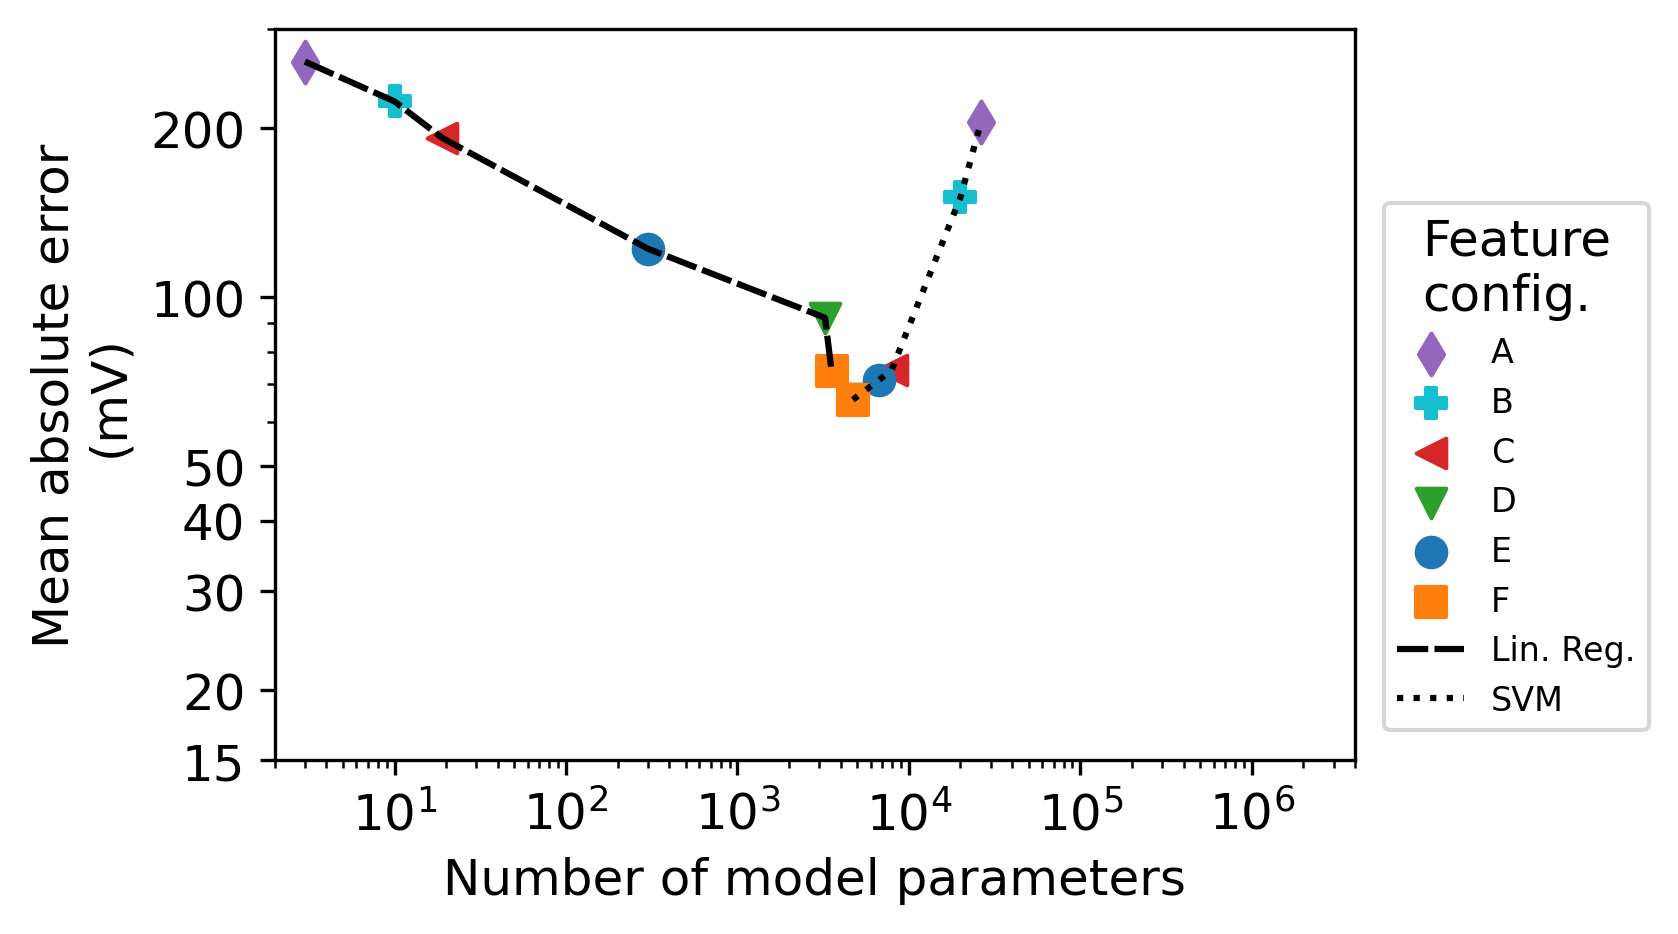

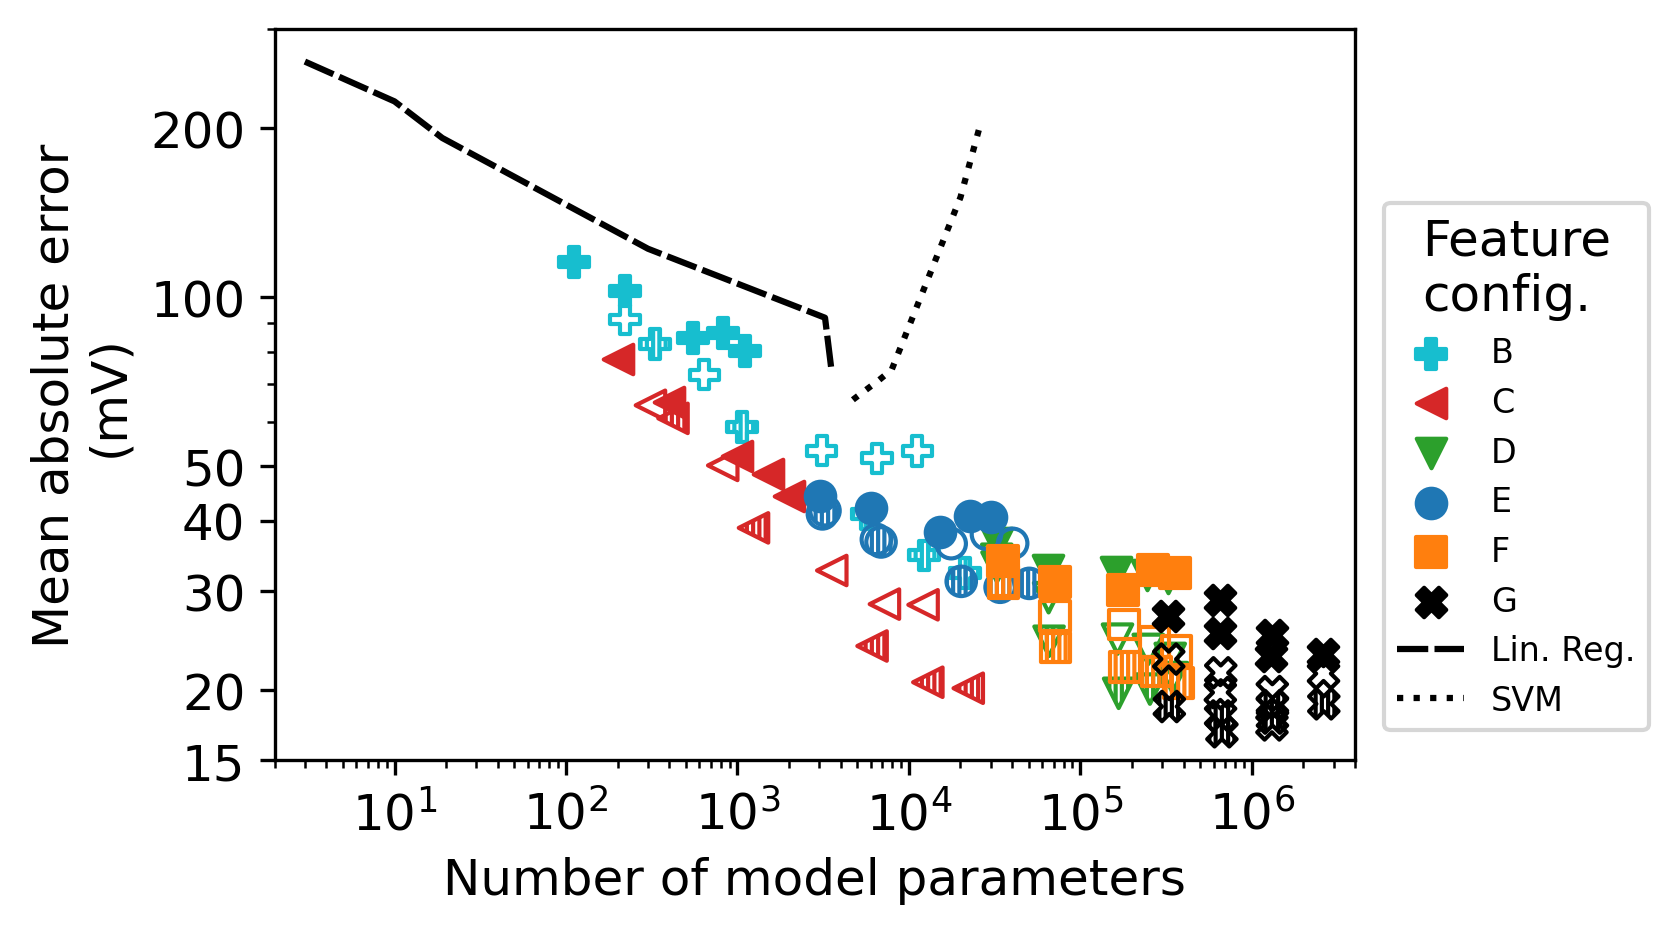

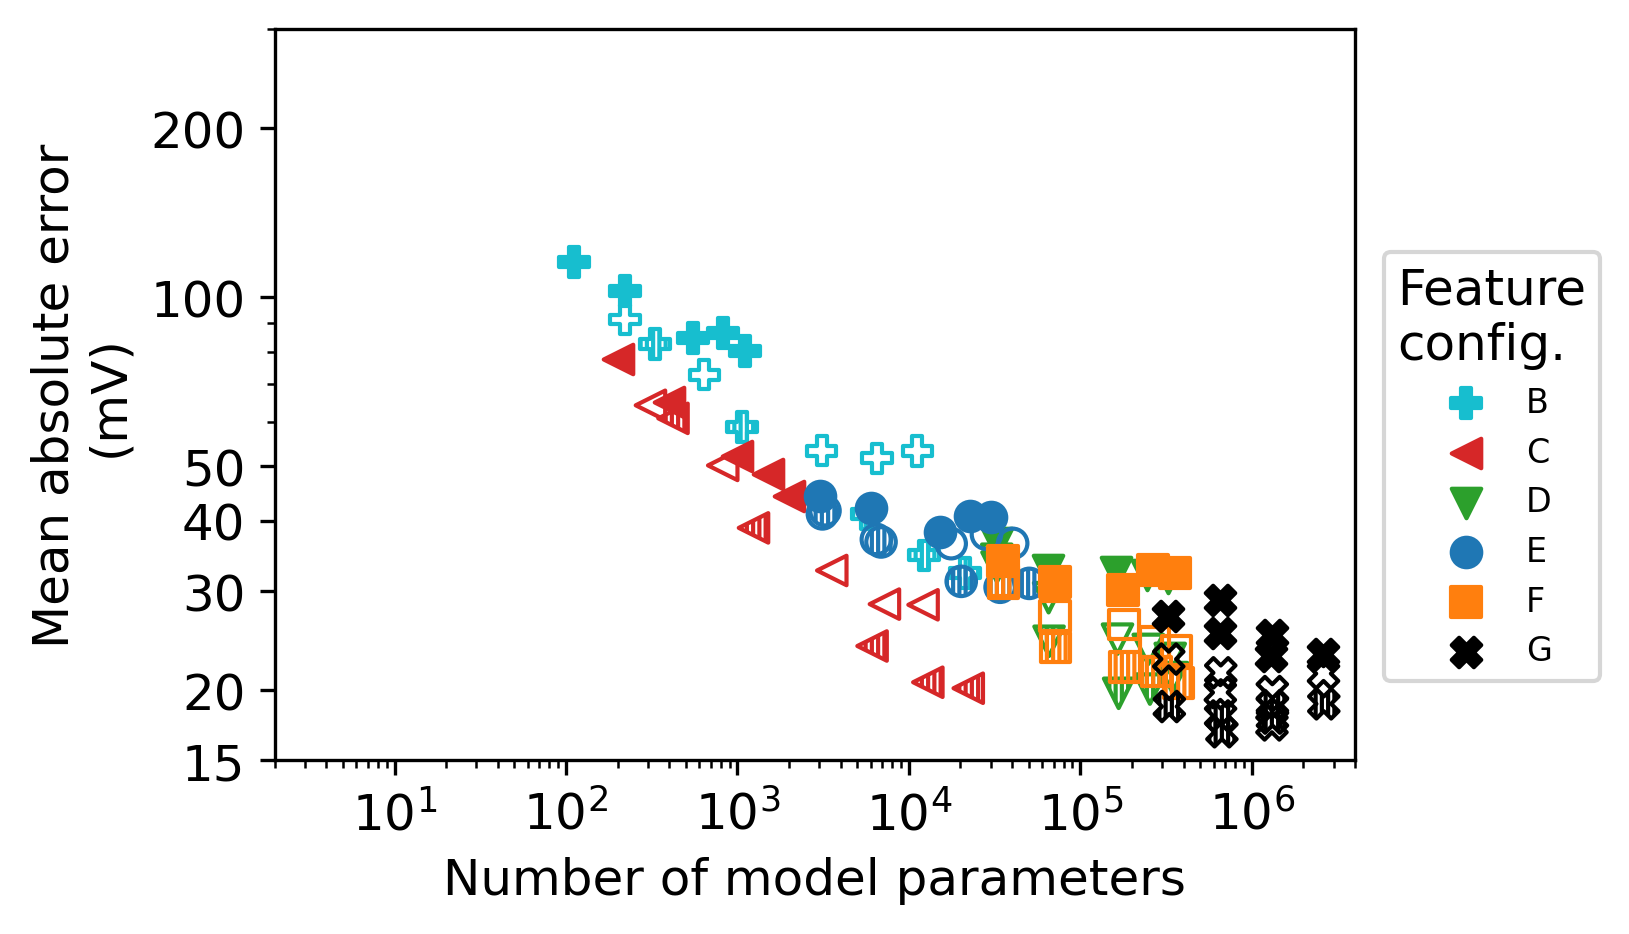

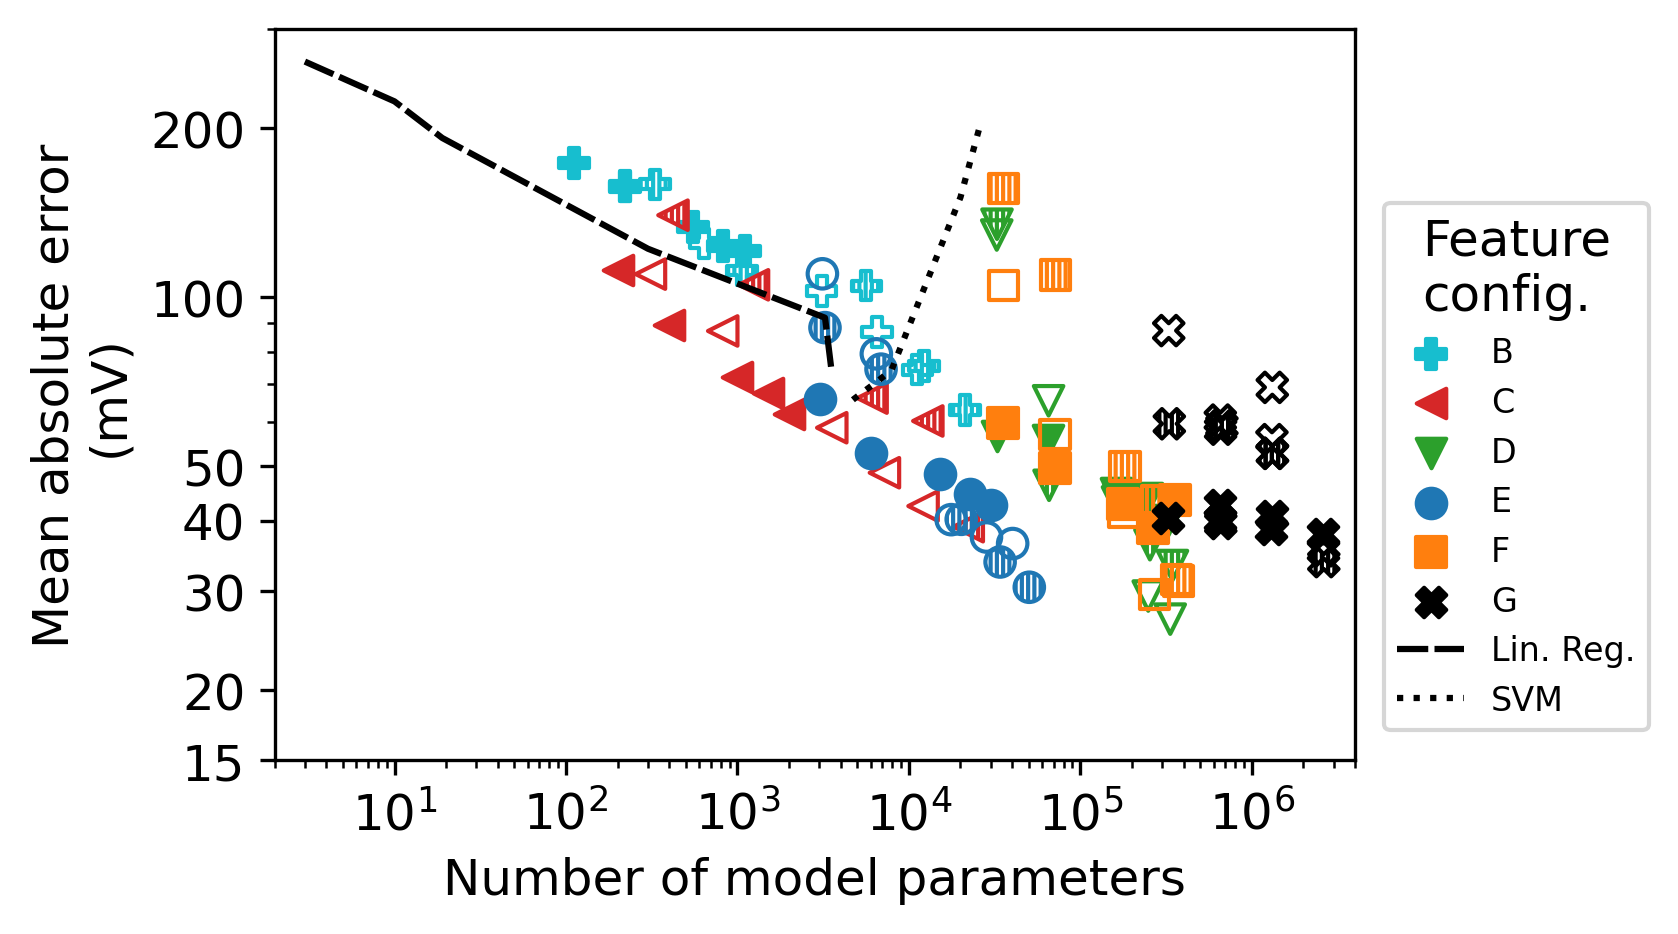

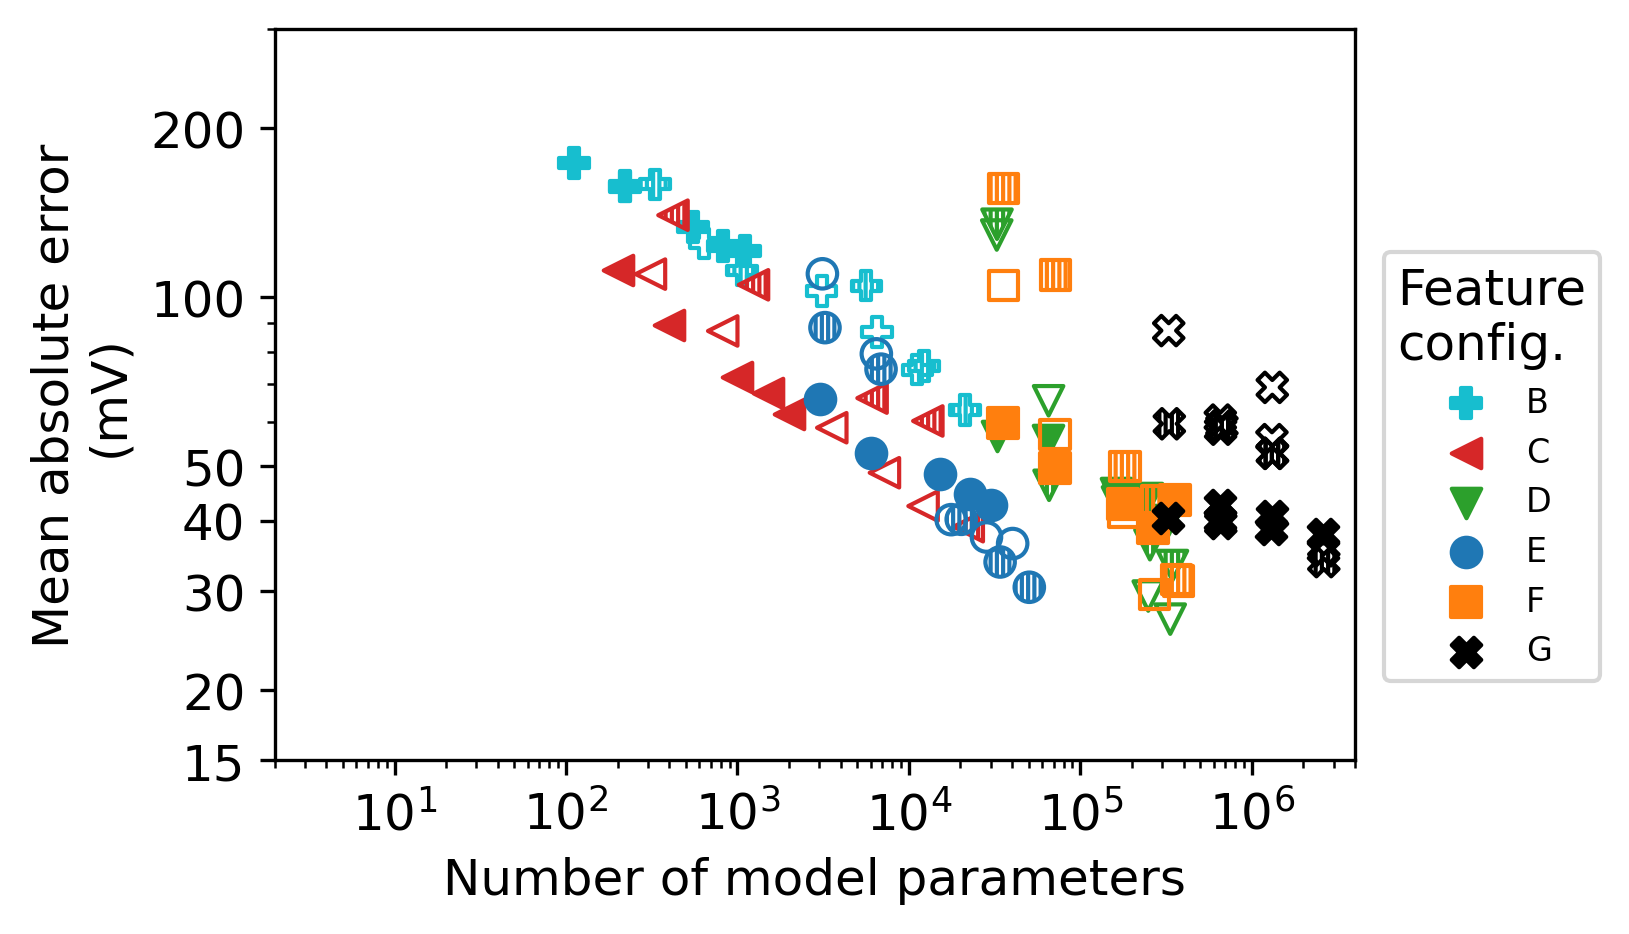

In [99]:
# %%
# No dropout:
mae_all_test = get_or_make_mae_tables(cell_config = 'cells_together')
plot_regression_cells_together(
    cell_config='cells_together', what_to_plot='only_classical_models')
plot_regression_cells_together(
    cell_config='cells_together', what_to_plot='classical_and_nn_models')
plot_regression_cells_together(
    cell_config='cells_together', what_to_plot='only_nn_models')

# With dropout:
mae_all_test = get_or_make_mae_tables(cell_config = 'cells_together_dropout')
plot_regression_cells_together(
    cell_config='cells_together_dropout', what_to_plot='classical_and_nn_models')
plot_regression_cells_together(
    cell_config='cells_together_dropout', what_to_plot='only_nn_models')


Read in the table containing test data MAE


Text(0.5, 0, 'Number of hidden layers')

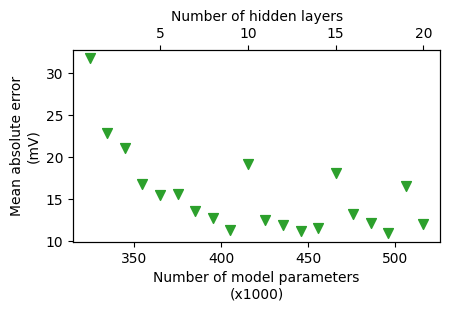

In [100]:
# %%
# Draw deep models
deep_representations = [
    'ffnn_1x100_sch2', 'ffnn_2x100_sch2', 'ffnn_3x100_sch2', 'ffnn_4x100_sch2', 'ffnn_5x100_sch2',
    'ffnn_6x100_sch2', 'ffnn_7x100_sch2', 'ffnn_8x100_sch2', 'ffnn_9x100_sch2', 'ffnn_10x100_sch2',
    'ffnn_11x100_sch2', 'ffnn_12x100_sch2', 'ffnn_13x100_sch2', 'ffnn_14x100_sch2', 'ffnn_15x100_sch2',
    'ffnn_16x100_sch2', 'ffnn_17x100_sch2', 'ffnn_18x100_sch2', 'ffnn_19x100_sch2', 'ffnn_20x100_sch2',
]
mae_all_test = get_or_make_mae_tables(cell_config = 'cells_together')

f, axs = plt.subplots(1,1,figsize=(4.5,3), constrained_layout=True)
ax_2 = axs.twiny()
f.patch.set_facecolor('white')
data_config = 'D'
s = 50
for i, representation in enumerate(deep_representations):
    repr_short = representation[:-5]
    n_params = model_params.loc[repr_short, data_config]
    mae_test = mae_all_test.loc[representation, data_config]
    axs.scatter(n_params/1000, mae_test*1000, marker=markers[data_config],
                edgecolors=cols[data_config], facecolors=cols[data_config],
                s=s)
    ax_2.scatter(i+1, mae_test*1000, s=0)
                  
axs.set_xlabel('Number of model parameters\n(x1000)')
axs.set_ylabel('Mean absolute error\n(mV)', horizontalalignment='center')
ax_2.set_xlabel('Number of hidden layers')


In [101]:
# %%
# ----------------------------------------------------------------------------------
# -------------------------------Cells separated-------------------------------------
# ----------------------------------------------------------------------------------

# MAE matrices
# cell_config = 'cells_separated'
cell_config = 'cells_separated_dropout'

path_mae_all_folded_test = os.path.join(models_path, cell_config,
     'mae_all_folded_test.csv')

if (not os.path.exists(path_mae_all_folded_test)):
    first_level = list(data_configs.keys())
    second_level = ['F{}'.format(i) for i in range(1,8)]
    multi_index = pd.MultiIndex.from_product([first_level, second_level])
    mae_all_folded_test = pd.DataFrame(index=representations, columns=multi_index)
else:
    mae_all_folded_test = pd.read_csv(os.path.join(models_path, cell_config,
        'mae_all_folded_test.csv'), header=[0, 1], index_col=0)


In [102]:
# %%
def make_mae_table_folds(cell_config, mae_all_folded_test):
    for data_config in data_configs.keys():
        print('Working on data config: {}'.format(data_config))
        for i, fold in enumerate(cells_separated_splits.keys()): # 
            X_train, y_train, X_val, y_val, X_test, y_test = config_data(data_config, fold)
            for representation in representations: #representations: | ['SVM']
                model_name = '{}_{}_{}'.format(representation, data_config, fold)
                model_dir = os.path.join(models_path, cell_config, model_name)
                if os.path.exists(model_dir) & \
                    np.isnan(mae_all_folded_test.loc[representation, (data_config, fold)]):
                    #
                    print('Working on: {}'.format(model_name))
                    if (representation != 'LinReg') & (representation != 'SVM'):
                        model = load_model(os.path.join(model_dir, model_name + '.h5'))
                        # Test
                        pred_test = model.predict(X_test)
                        mae_test = np.average(np.abs(y_test-pred_test))
                        mae_all_folded_test.loc[
                            representation, (data_config, fold)] = round(mae_test,8)
                    else:
                        with open(os.path.join(model_dir, model_name + '.sav'), 'rb') as fa:
                            model = pickle.load(fa)
                        with open(os.path.join(model_dir, 'scaler.sav'), 'rb') as fa:
                            scaler = pickle.load(fa)
                        # Test
                        print('Inference on test data')
                        pred_test = model.predict(scaler.transform(X_test))
                        mae_test = np.average(np.abs(y_test-pred_test.reshape(-1,1)))
                        mae_all_folded_test.loc[
                            representation, (data_config, fold)] = round(mae_test,8)

            del (X_train, y_train, X_val, y_val, X_test, y_test)
        return mae_all_folded_test

def get_or_make_mae_folded_tables(cell_config = 'cells_together'):
    """
    cell config: 'cells_together' | 'cells_together_dropout'
    """
    path_mae_all_folded_test = os.path.join(models_path, cell_config,
        'mae_all_folded_test.csv')

    if (not os.path.exists(path_mae_all_folded_test)):
        first_level = list(data_configs.keys())
        second_level = ['F{}'.format(i) for i in range(1,8)]
        multi_index = pd.MultiIndex.from_product([first_level, second_level])
        mae_all_folded_test = pd.DataFrame(index=representations, columns=multi_index)
        print('Constructing the table containing test data MAE')
        mae_all_folded_test = make_mae_table_folds(cell_config, mae_all_folded_test)
        print('Saving the table')
        mae_all_folded_test.to_csv(path_mae_all_folded_test)
    else:
        print('Read in the table containing test data MAE')
        mae_all_folded_test = pd.read_csv(
            path_mae_all_folded_test, header=[0, 1], index_col=0)
    return mae_all_folded_test


In [113]:
# %%
def plot_regression_cells_separated(
    cell_config, what_to_plot='only_classical_models', save_this_figure=False):

    """
    what_to_plot: 'only_classical_models' | 'only_nn_models' | 'classical_and_nn_models'
    """
    assert (what_to_plot in ['only_classical_models',
                             'only_nn_models', 'classical_and_nn_models'])

    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)
    mpl.rc('legend', fontsize=8, title_fontsize=12)
    mpl.rc('font', size=12)

    if what_to_plot == 'only_classical_models':
        only_classical_models, only_nn_models,  classical_and_nn_models = True, False, False
        data_configs_to_plot = ['A', 'B', 'C', 'D', 'E', 'F']
    elif what_to_plot == 'only_nn_models':
        only_classical_models, only_nn_models,  classical_and_nn_models = False, True, False
        data_configs_to_plot = ['B', 'C', 'D', 'E', 'F', 'G']
    elif what_to_plot == 'classical_and_nn_models':
        only_classical_models, only_nn_models,  classical_and_nn_models = False, False, True
        data_configs_to_plot = ['B', 'C', 'D', 'E', 'F', 'G']

    f, axs = plt.subplots(1,1,figsize=(4.5,3), constrained_layout=True, dpi=300)
    f.patch.set_facecolor('white')
    for data_config in data_configs_to_plot:
        for i, representation in enumerate(representations):
            if only_classical_models & (i>1):
                continue
            elif only_nn_models & (i<=1):
                continue
            elif classical_and_nn_models & (i<2):
                continue
            
            if 'sch2' in representation:
                repr_short = representation[:-5]
                n_params = model_params.loc[repr_short, data_config]
            elif ('LinReg' in representation):
                n_params = model_params.loc[representation, data_config]
            # For SVM it's fold-specific

            for j, fold in enumerate(cells_separated_splits.keys()):
                if ('SVM' in representation):
                    n_params = svm_model_params_separated.loc['SVM', (data_config, fold)]
                # ------------------------------------------------
                # if qualifies_by_epoch.loc[representation, (data_config, fold)]:
                mae_test = mae_all_folded_test.loc[representation, (data_config, fold)]
                if only_classical_models & (i == 0) & (j == 0):
                    label = data_config
                elif classical_and_nn_models & (i == 2) & (j == 0):
                    label = data_config
                elif only_nn_models & (i == 2) & (j == 0):
                    label = data_config
                else:
                    label = None

                if '_2x' in representation:
                    facecolors='none'
                    hatch =  None # None | '///////'
                elif '_3x' in representation:
                    facecolors='none'
                    hatch = '||||||||'
                else:
                    facecolors=cols[data_config]
                    hatch = None
                axs.scatter(n_params, mae_test*1000, label=label, marker=markers[data_config],
                            facecolors=facecolors, edgecolors=cols[data_config],
                            hatch=hatch, s=12)

                # ------------------------------------------------
                # if not mae_all_folded_test.loc[representation, data_config].isna().all():
                #     mae_test_mean = mae_all_folded_test.loc[representation, data_config].mean()
                #     mae_test_max = mae_all_folded_test.loc[representation, data_config].max()
                #     mae_test_min = mae_all_folded_test.loc[representation, data_config].min()

                #     if (i==17) & (j==0) & (data_config == 'G'):
                #         label = data_config
                #     axs.scatter(n_params, mae_test_mean*1000, label=label, marker=markers[data_config],
                #                 facecolors=facecolors, edgecolors=cols[data_config],
                #                 hatch=hatch, s=10)
                #     # Calculate error bar lengths
                #     yerr = [
                #         [mae_test_mean*1000 - mae_test_min*1000],
                #         [mae_test_max*1000 - mae_test_mean*1000]]
                #     axs.errorbar(n_params, mae_test_mean*1000, yerr=yerr, label=None, marker=None,
                #                 markerfacecolor =facecolors, markeredgecolor=cols[data_config],
                #                 ecolor=cols[data_config], elinewidth=0.5, capsize=2, capthick=0.5)
                # ------------------------------------------------

    if only_classical_models | classical_and_nn_models:
        # Draw Line for the Linear Regression
        # for j, fold in enumerate(cells_separated_splits.keys()):
        #     mae_test = []
        #     n_params = []
        #     for data_config in data_configs.keys():
        #         mae_test.append(mae_all_folded_test.loc['LinReg', (data_config, fold)]*1000)
        #         n_params.append(model_params.loc['LinReg', data_config])
        #     n_params = np.array(n_params)
        #     mae_test = np.array(mae_test)
        #     sorted_indices = np.argsort(n_params)
        #     if j == 0:
        #         label = 'Lin. Reg.'
        #     else:
        #         label = None
        #     axs.plot(n_params[sorted_indices], mae_test[sorted_indices], color='k', 
        #             linestyle = (0, (5, 1)), linewidth = 1, label = label)

        # Draw a filled area instead
        mae_test_grid = np.empty((7, len(data_configs)-1))
        for j, fold in enumerate(cells_separated_splits.keys()):
            mae_test = []
            n_params = []
            for data_config in data_configs.keys():
                if data_config != 'G':
                    mae_test.append(mae_all_folded_test.loc['LinReg', (data_config, fold)]*1000)
                    n_params.append(model_params.loc['LinReg', data_config])
            n_params = np.array(n_params)
            sorted_indices = np.argsort(n_params)
            mae_test = np.array(mae_test)
            mae_test_grid[j] = mae_test[sorted_indices]
        # mae_test_all_folds = mae_test_all_folds[:, sorted_indices]
        maxima, minima = [], []
        for i in range(len(n_params)):
            maxima.append(mae_test_grid[:, i].max())
            minima.append(mae_test_grid[:, i].min())
        axs.fill_between(n_params[sorted_indices], maxima, minima,
                        color='tab:olive', alpha = 0.2, 
                        label = 'Lin. Reg.')    

        # Draw Line for SVM
        # for j, fold in enumerate(cells_separated_splits.keys()):
        #     mae_test = []
        #     n_params = []
        #     for data_config in data_configs.keys():
        #         mae_test.append(mae_all_folded_test.loc['SVM', (data_config, fold)]*1000)
        #         n_params.append(svm_model_params_separated.loc['SVM', (data_config, fold)])
        #     n_params = np.array(n_params)
        #     mae_test = np.array(mae_test)
        #     sorted_indices = np.argsort(n_params)
        #     if j == 0:
        #         label = 'SVM.'
        #     else:
        #         label = None
        #     axs.plot(n_params[sorted_indices], mae_test[sorted_indices], color='k',
        #             linestyle = ':', label = label)

        # Draw a filled area instead
        for j, fold in enumerate(cells_separated_splits.keys()):
            mae_test = []
            n_params = []
            for data_config in data_configs.keys():
                if data_config != 'G':
                    mae_test.append(mae_all_folded_test.loc['SVM', (data_config, fold)]*1000)
                    n_params.append(svm_model_params_separated.loc['SVM', (data_config, fold)])
            n_params = np.array(n_params)
            mae_test = np.array(mae_test)
            sorted_indices = np.argsort(n_params)
            mae_test_grid[j] = mae_test[sorted_indices]

        mae_maxima, mae_minima = [], []
        for i in range(len(n_params)):
            mae_maxima.append(mae_test_grid[:, i].max())
            mae_minima.append(mae_test_grid[:, i].min())
        axs.fill_between(n_params[sorted_indices], mae_maxima, mae_minima,
                        color='k', alpha = 0.2, 
                        label = 'SVM')
                        
    axs.set_xlim(2*1E0, 4*1E6)   
    axs.set_ylim(1E2, 2.5*1E5)
    axs.set_yscale('log')
    axs.set_xscale('log')

    axs.set_yticks([100,1000,10000,100000])

    def custom_formatter(x, pos):
        if x in [100]:
            return f'{int(x)}'
        elif x in [1000, 10000, 100000]:
            return f'$10^{int(np.log10(x))}$'
        else:
            return f'{x:.0e}'
    import matplotlib.ticker as ticker
    axs.get_yaxis().set_major_formatter(ticker.FuncFormatter(custom_formatter))
    # axs.get_yaxis().set_major_formatter(plt.ScalarFormatter())

    axs.set_xlabel('Number of model parameters')
    axs.set_ylabel('Mean absolute error\n(mV)', horizontalalignment='center')
    f.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Feature\nconfig.',
            markerscale=2)

    if cell_config == 'cells_separated_dropout':
        save_filename = 'cells_separated_dropout'
    elif only_classical_models:
        save_filename = 'cells_separated_benchmark_results'
    elif classical_and_nn_models:
        save_filename = 'cells_separated_results_all'
    if save_this_figure == True:
        utils.save_figure(f, visualistion_path, save_filename, format='pdf')

    mpl.rcdefaults()

Read in the table containing test data MAE
Read in the table containing test data MAE


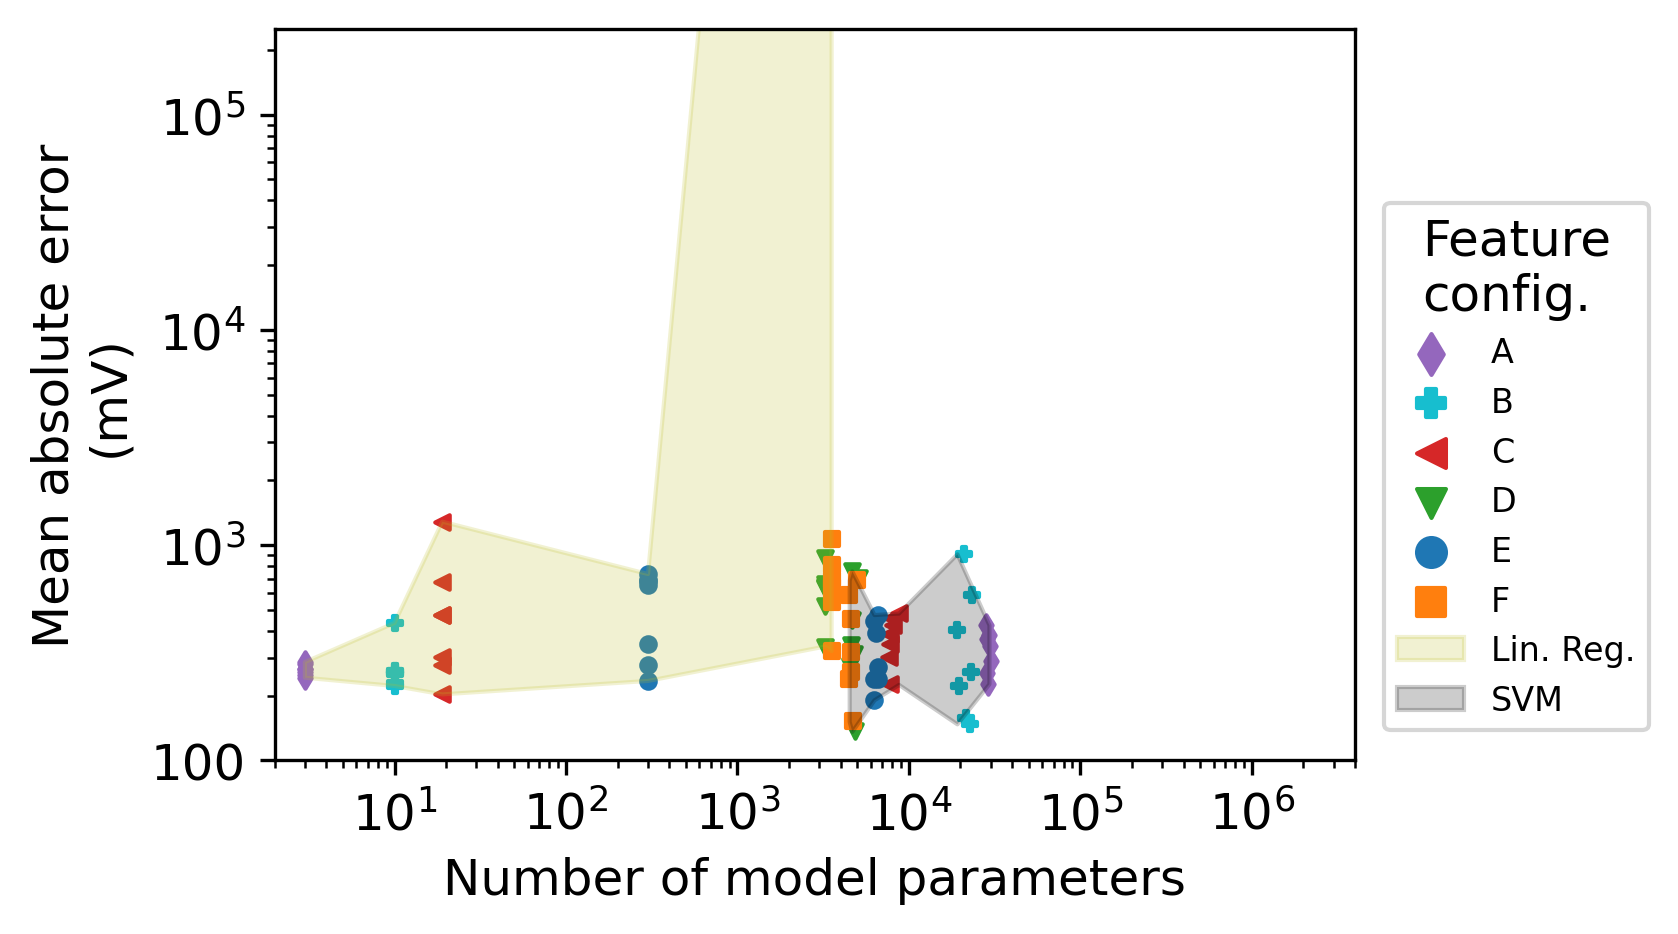

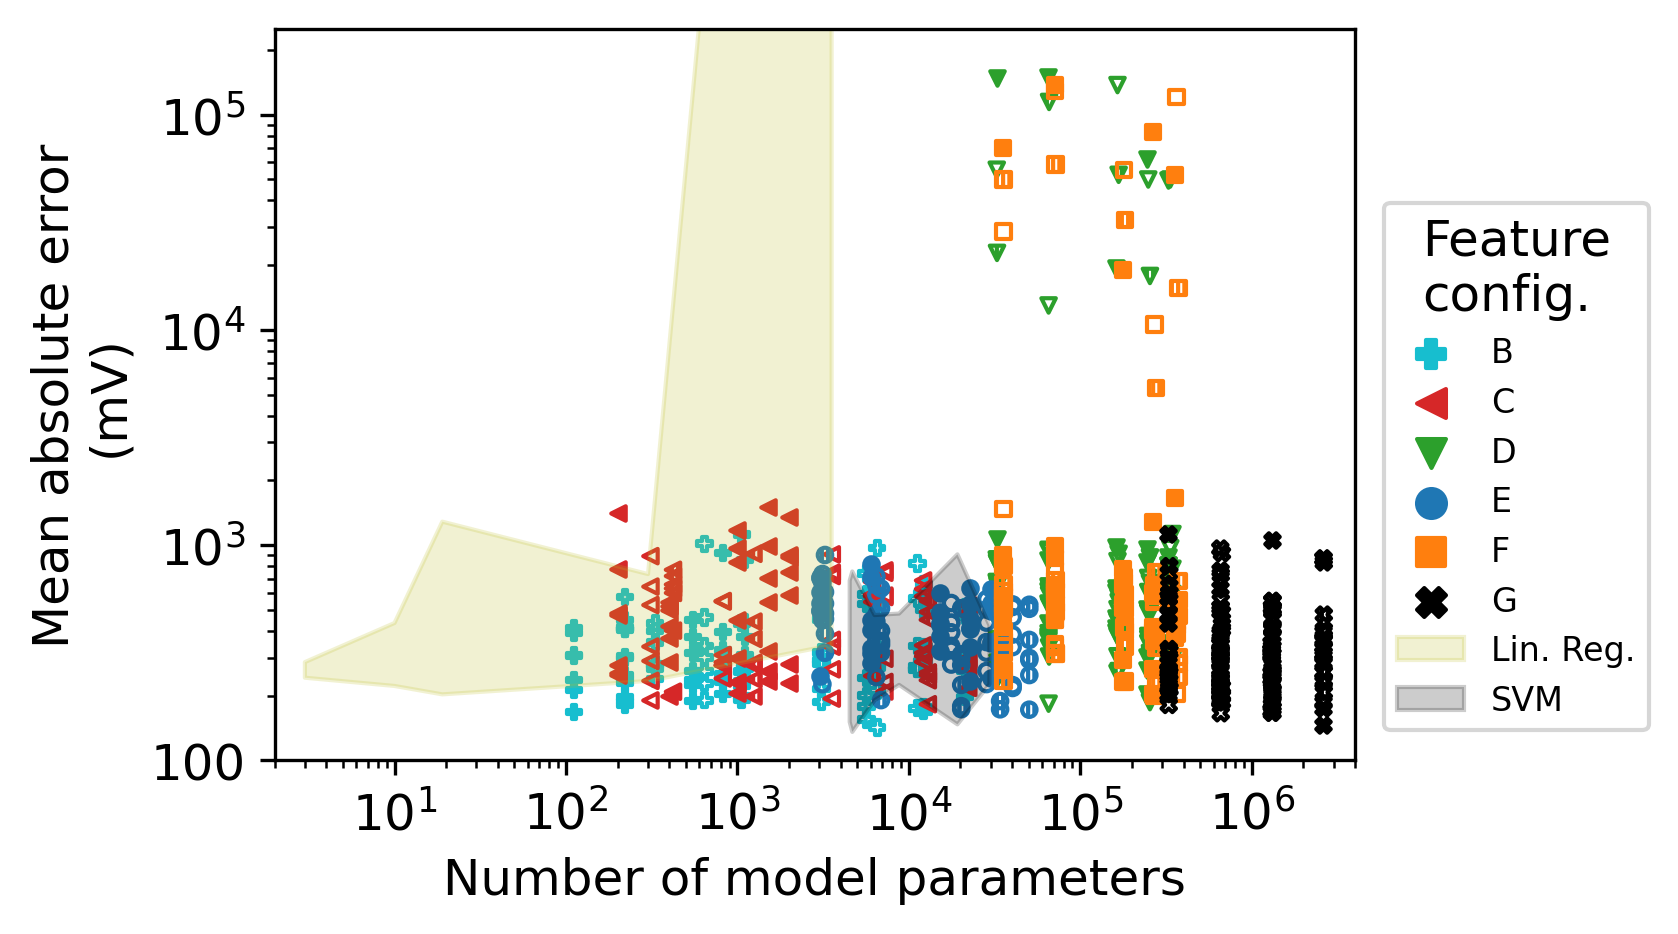

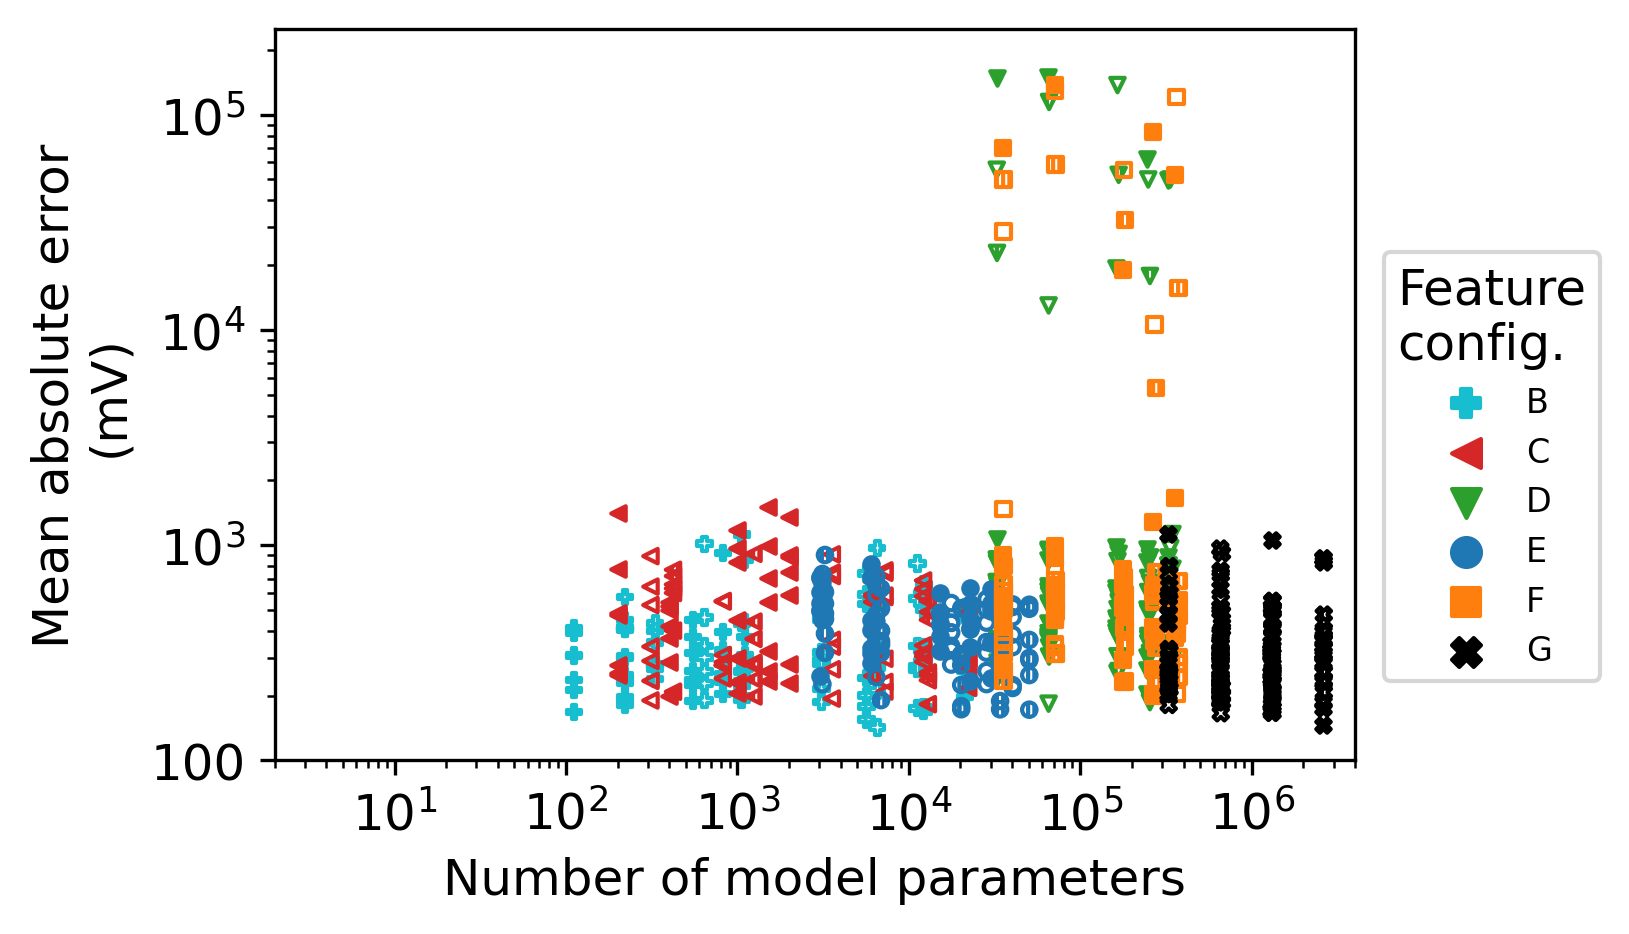

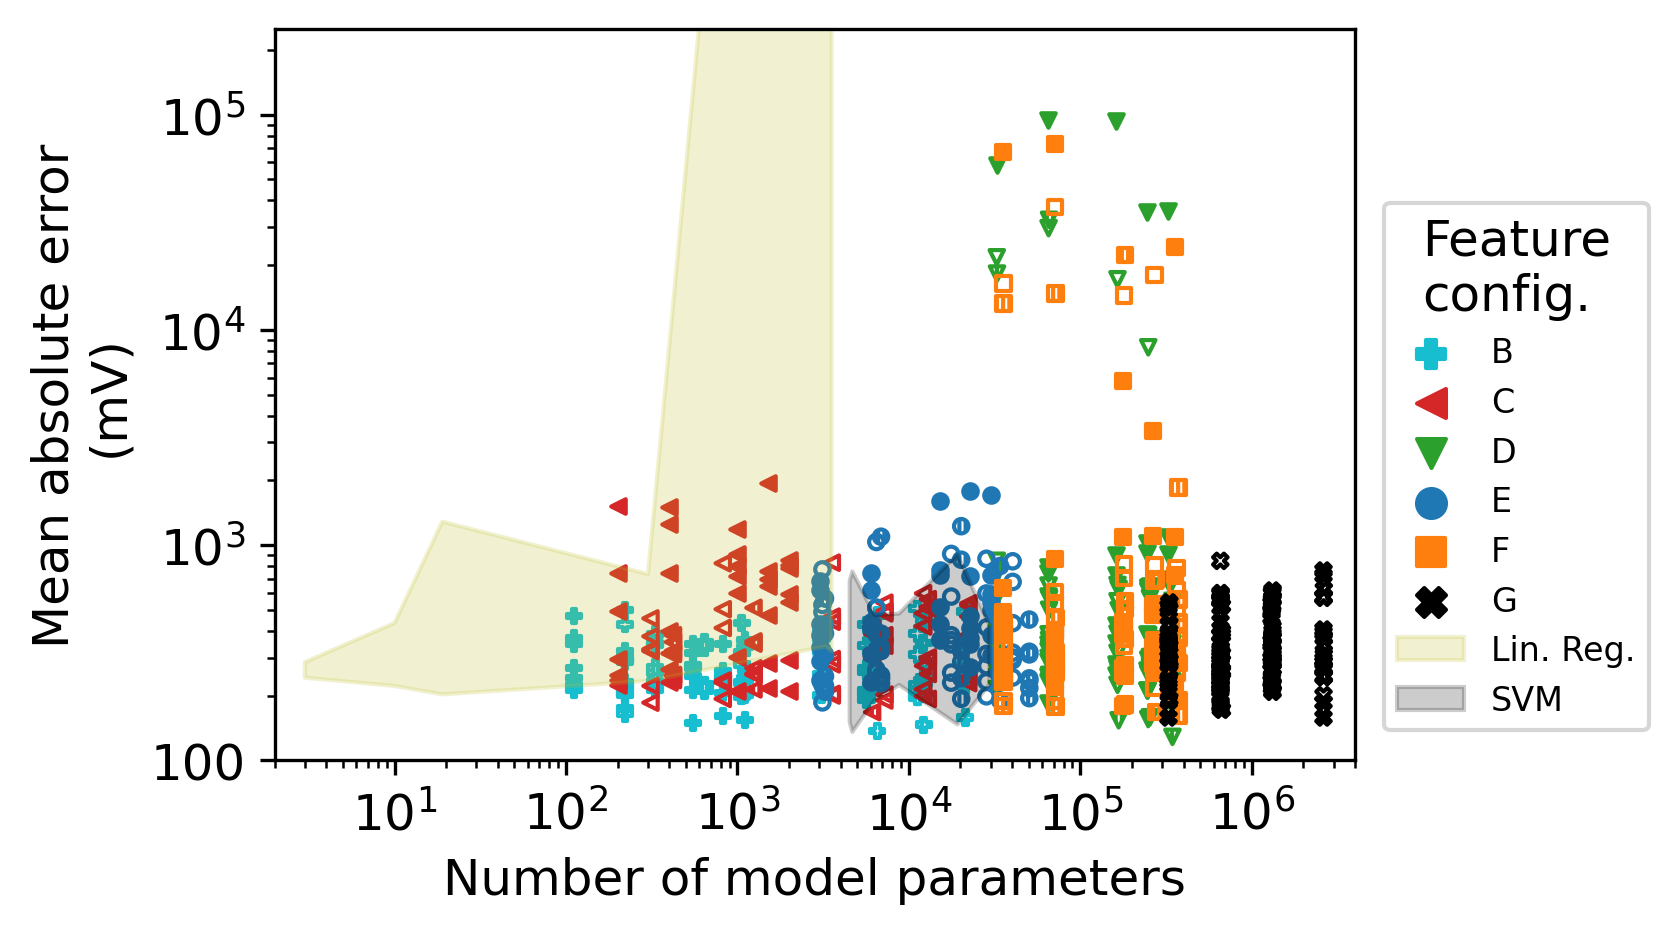

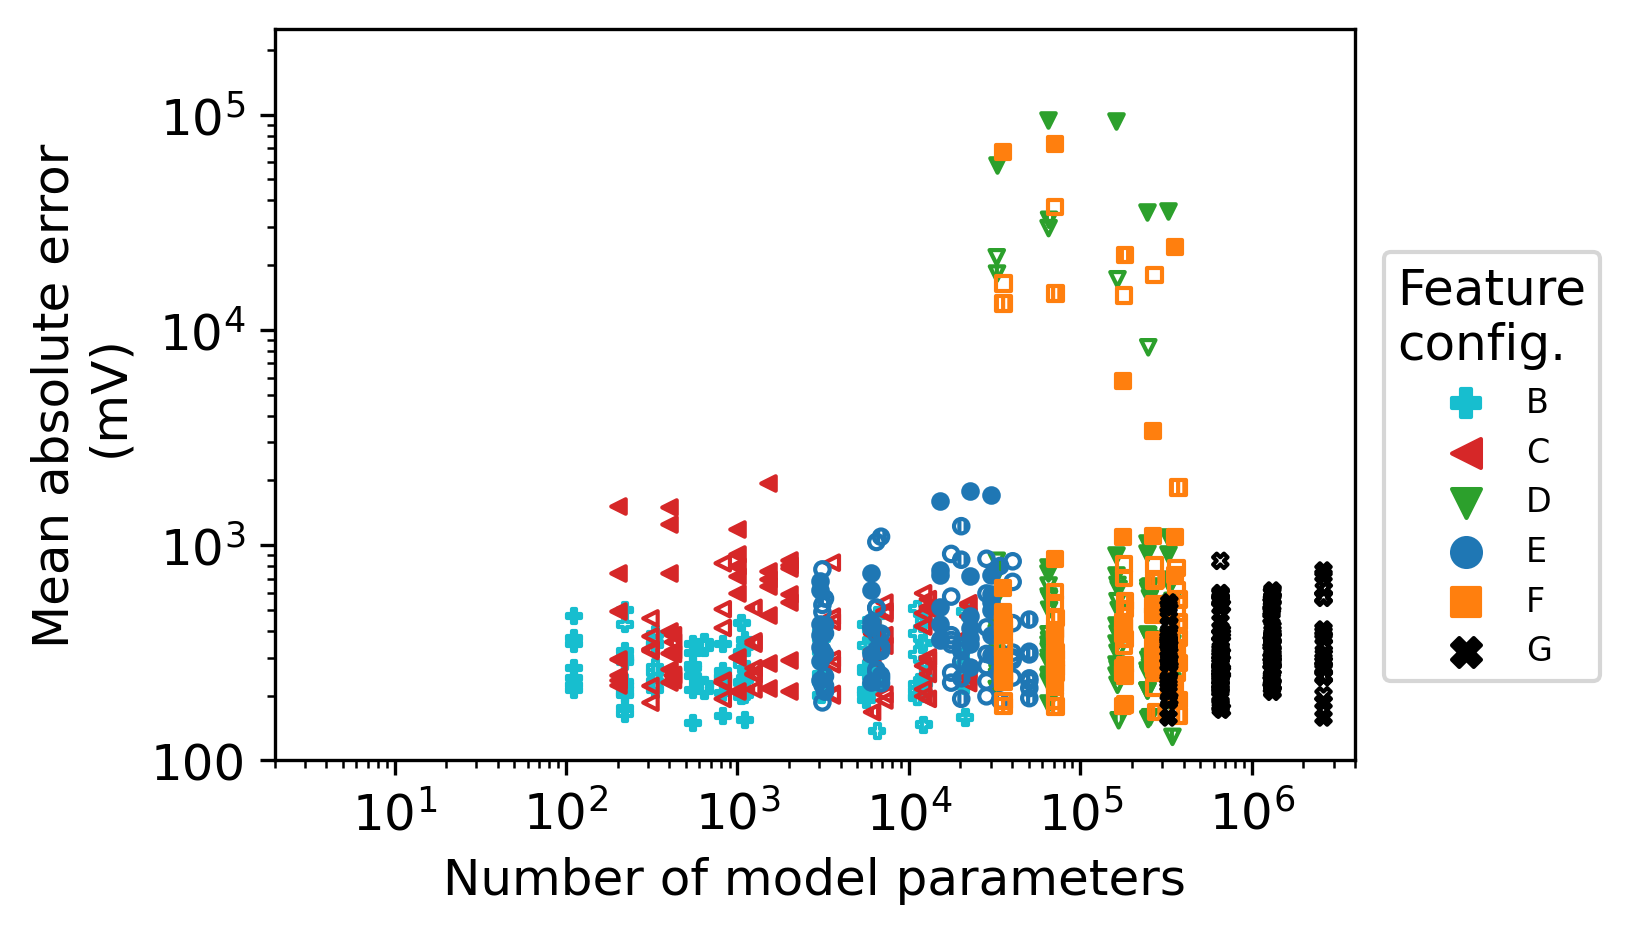

In [114]:
# %%
# No dropout:
mae_all_folded_test = get_or_make_mae_folded_tables(cell_config = 'cells_separated')
plot_regression_cells_separated(
    cell_config='cells_separated', what_to_plot='only_classical_models', save_this_figure=True)
plot_regression_cells_separated(
    cell_config='cells_separated', what_to_plot='classical_and_nn_models', save_this_figure=True)
plot_regression_cells_separated(
    cell_config='cells_separated', what_to_plot='only_nn_models')

# With dropout:
mae_all_folded_test = get_or_make_mae_folded_tables(cell_config = 'cells_separated_dropout')
plot_regression_cells_separated(
    cell_config='cells_separated_dropout', what_to_plot='classical_and_nn_models', save_this_figure=True)
plot_regression_cells_separated(
    cell_config='cells_separated_dropout', what_to_plot='only_nn_models')


In [ ]:
# %%
# ----------------------------------------------------------------------------------
# -----------------------Investigate the training process---------------------------
# ----------------------------------------------------------------------------------

# Get number of training epochs for cell_config = 'cells_separated'
cell_config = 'cells_separated'
first_level = list(data_configs.keys())
second_level = ['F{}'.format(i) for i in range(1,8)]
multi_index = pd.MultiIndex.from_product([first_level, second_level])
epochs_all_folded = pd.DataFrame(index=representations, columns=multi_index)
for data_config in data_configs.keys():
    print('Working on data config: {}'.format(data_config))
    for i, fold in enumerate(cells_separated_splits.keys()):
        for representation in representations[2:]:
            model_name = '{}_{}_{}'.format(representation, data_config, fold)
            model_dir = os.path.join(models_path, cell_config, model_name)
            if os.path.exists(model_dir):
                with open(os.path.join(model_dir,'training_history.json'), 'r') as fp:
                    training_history = json.load(fp)
                    n_epochs = len(training_history['loss'])
                    epochs_all_folded.loc[
                        representation, (data_config, fold)] = n_epochs
n_epochs_all_folded = epochs_all_folded.to_numpy()


In [ ]:
# %%
# Get number of training epochs for cell_config = 'cells_separated_dropout'
cell_config = 'cells_separated_dropout'
first_level = list(data_configs.keys())
second_level = ['F{}'.format(i) for i in range(1,8)]
multi_index = pd.MultiIndex.from_product([first_level, second_level])
epochs_all_folded = pd.DataFrame(index=representations, columns=multi_index)
for data_config in data_configs.keys():
    print('Working on data config: {}'.format(data_config))
    for i, fold in enumerate(cells_separated_splits.keys()):
        for representation in representations[2:]:
            model_name = '{}_{}_{}'.format(representation, data_config, fold)
            model_dir = os.path.join(models_path, cell_config, model_name)
            if os.path.exists(model_dir):
                with open(os.path.join(model_dir,'training_history.json'), 'r') as fp:
                    training_history = json.load(fp)
                    n_epochs = len(training_history['loss'])
                    epochs_all_folded.loc[
                        representation, (data_config, fold)] = n_epochs
n_epochs_all_folded_dropout = epochs_all_folded.to_numpy()


In [ ]:
# %%
# Get number of training epochs for cell_config = 'cells_together'
cell_config = 'cells_together'
epochs_all = pd.DataFrame(index = representations, columns = data_configs.keys())
for data_config in data_configs.keys():
    for representation in representations[2:]:
        model_name = '{}_{}'.format(representation, data_config)
        model_dir = os.path.join(models_path, cell_config, model_name)        
        if os.path.exists(model_dir):
            with open(os.path.join(model_dir,'training_history.json'), 'r') as fp:
                training_history = json.load(fp)
                n_epochs = len(training_history['loss'])
                epochs_all.loc[representation, data_config] = n_epochs
n_epochs_all = epochs_all.to_numpy()


In [ ]:
# %%
# Get number of training epochs for cell_config = 'cells_together_dropout'
cell_config = 'cells_together_dropout'
epochs_all = pd.DataFrame(index = representations, columns = data_configs.keys())
for data_config in data_configs.keys():
    for representation in representations[2:]:
        model_name = '{}_{}'.format(representation, data_config)
        model_dir = os.path.join(models_path, cell_config, model_name)        
        if os.path.exists(model_dir):
            with open(os.path.join(model_dir,'training_history.json'), 'r') as fp:
                training_history = json.load(fp)
                n_epochs = len(training_history['loss'])
                epochs_all.loc[representation, data_config] = n_epochs
n_epochs_all_dropout = epochs_all.to_numpy()


In [ ]:
# %%
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=8, title_fontsize=12)
mpl.rc('font', size=12)

hist_bins = list(range(0,8100,100))
# hist_bins = 30
f, axs = plt.subplots(2, 2, figsize=(8*1.2,5), dpi=300,
                      constrained_layout=True, sharex='col', sharey='col')
f.patch.set_facecolor('white')
axs[0,0].hist(n_epochs_all[~np.isnan(n_epochs_all.astype(float))],
         bins=hist_bins, edgecolor='black')
axs[0,1].hist(n_epochs_all_folded[~np.isnan(n_epochs_all_folded.astype(float))],
         bins=hist_bins, edgecolor='black')
axs[1,0].hist(n_epochs_all_dropout[~np.isnan(n_epochs_all_dropout.astype(float))],
         bins=hist_bins, edgecolor='black')
axs[1,1].hist(n_epochs_all_folded_dropout[~np.isnan(n_epochs_all_folded_dropout.astype(float))],
         bins=hist_bins, edgecolor='black')

axs[0,0].set_title("(a)\n'All cells'\ndata split")
axs[0,1].set_title("(b)\n'Held out cells'\ndata splits")
axs[0,0].set_xticks([500,2000,4000,6000,8000])
axs[0,1].set_xticks([500,2000,4000,6000,8000])
f.supylabel('Number of\nmodels', horizontalalignment='center')
f.supxlabel('Epoch number at the point of\ntraining termination')

axs[0,0].set_xlim(0, 8400)

save_filename = 'histograms_epochs'
utils.save_figure(f, visualistion_path, save_filename, format='pdf')
utils.save_figure(f, visualistion_path, save_filename, format='png')

mpl.rcdefaults()


In [ ]:
# %%